In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing
from datetime import datetime
from datetime import date
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import pydotplus

In [194]:
# Load test and train from phase 2
test = pd.read_csv('dataset/test.csv')
train = pd.read_csv('dataset/train.csv')
dataset = pd.read_csv('dataset/train_test.csv')

In [195]:
X = dataset.drop(columns=['ssn', 'indicator'])
y = dataset.indicator

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Fáza 3 - Strojové učenie


## 1.Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu
Naimplementujte 1R algorithm (1R or OneR), ktorý je jednoduchá klasifikácia t.j. rozhodnutie na základe jedného atribútu. Môžete implementovať komplikovanejšie t.j. zahŕňajúce viacero atribútov (ich kombinácie).
Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Vyhodnoťte klasifikátor pomocou metrík accuracy, precision a recall.


In [ ]:
def OneR(X_train):
    overall_best_acc = 0
    overall_best_column = None
    overall_best_predictor = None

    for column in ['leukocyty', 'trombocyty', 'alp', 'hbver', 'hemoglobin']:
        data = train [[column, 'indicator']]
        sorted_data = data.drop_duplicates([column], keep='last').sort_values(column)
        length = len(sorted_data)

        best_acc = 0
        best_column = None
        best_predictor = None
        for i in range(1, length):
            ind_one_left = 0
            ind_zero_left = 0

            ind_one_right = 0
            ind_zero_right = 0

            pom = 0
            for index, row in sorted_data.iterrows():
                if pom < i:
                    if row['indicator'] == 1.0:
                        ind_one_left += 1
                    else:
                        ind_zero_left += 1
                else:
                    if row['indicator'] == 0.0:
                        ind_zero_right += 1
                    else:
                        ind_one_right += 1
                pom += 1

            acc_one_left = ind_one_left + ind_zero_right
            acc_zero_left = ind_zero_left + ind_one_right
            acc = acc_one_left / length if acc_one_left / length >= acc_zero_left / length else acc_zero_left / length

            if best_acc < acc:
                best_acc = acc
                best_column = column
                best_predictor = sorted_data.at[i+1, column]

                if acc_one_left / length >= acc_zero_left / length:
                    predicting = 1
                else:
                    predicting = 0


        if overall_best_acc <= best_acc:
            overall_best_acc = best_acc
            overall_best_column = best_column
            overall_best_predictor = best_predictor
            overall_predicting = predicting
            
    return overall_best_acc, overall_best_column, overall_best_predictor, overall_predicting

In [199]:
overall_best_acc, overall_best_column, overall_best_predictor, overall_predicting = OneR(X_train)

print(f"Column : {overall_best_column}")
print(f"Predictor : {overall_best_predictor}")
print(f"Accuracy : {overall_best_acc}")
print(f"Predicting_left : {overall_predicting}")

Column : trombocyty
Predictor : 0.4295006049175594
Accuracy : 0.7328304882890035
Predicting_left : 0


In [53]:
def predict_oneR():
    predicted = []
    for index, row in test.iterrows():
        if row[overall_best_column] < overall_best_predictor:
            predicted.append(overall_predicting)
        elif overall_predicting == 0:
            predicted.append(1.)
        else:
            predicted.append(0.)
    predicted = np.array(predicted)
    return predicted


In [138]:
def prediction_of_oneR():
    predicted_oneR = predict_oneR()
    oneR_summary = classification_report(test['indicator'], predicted_oneR, output_dict=True)
    oneR_summary = pd.DataFrame(oneR_summary).transpose()
    return oneR_summary

oneR_summary = prediction_of_oneR()
print(oneR_summary)

              precision    recall  f1-score      support
0.0            0.683955  0.460699  0.550554   916.000000
1.0            0.741361  0.878957  0.804317  1611.000000
accuracy       0.727345  0.727345  0.727345     0.727345
macro avg      0.712658  0.669828  0.677436  2527.000000
weighted avg   0.720552  0.727345  0.712332  2527.000000


## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia
Na trénovanie využite minimálne jeden stromový algoritmus strojového učenia v scikit-learn.
Vizualizujte natrénované pravidlá.
Vyhodnoťte natrénovaný model pomocou metrík accuracy, precision a recall
Porovnajte natrénovaný klasifikátor s Vašimi manuálne vytvorenými pravidlami z prvého kroku.


In [59]:
def decisionTree(clf):
    clf = clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    decisionTree_summary = classification_report(y_test, pred, output_dict=True)
    decisionTree_summary = pd.DataFrame(decisionTree_summary).transpose()
    return decisionTree_summary

clf = DecisionTreeClassifier(criterion='entropy')
decisionTree_summary = decisionTree(clf)
decisionTree_summary

,precision,recall,f1-score,support
0.0,0.849231,0.844037,0.846626,654.000000
1.0,0.908847,0.912108,0.910474,1115.000000
accuracy,0.886942,0.886942,0.886942,0.886942
macro avg,0.879039,0.878072,0.878550,1769.000000
weighted avg,0.886807,0.886942,0.886870,1769.000000


In [56]:
pd.concat([decisionTree_summary[['precision', 'recall', 'f1-score', 'support']], oneR_summary[['precision', 'recall', 'f1-score', 'support']]], axis=1, keys=['decisionTree_summary', 'oneR_summary'])

decisionTree_summary                                   \
                        precision    recall  f1-score      support   
0.0                      0.850539  0.844037  0.847276   654.000000   
1.0                      0.908929  0.913004  0.910962  1115.000000   
accuracy                 0.887507  0.887507  0.887507     0.887507   
macro avg                0.879734  0.878521  0.879119  1769.000000   
weighted avg             0.887342  0.887507  0.887417  1769.000000   

             oneR_summary                                   
                precision    recall  f1-score      support  
0.0              0.683955  0.460699  0.550554   916.000000  
1.0              0.741361  0.878957  0.804317  1611.000000  
accuracy         0.727345  0.727345  0.727345     0.727345  
macro avg        0.712658  0.669828  0.677436  2527.000000  
weighted avg     0.720552  0.727345  0.712332  2527.000000

V tomto prípade majú obidva testy pekné výsledky, ale vyzerá to tak, že by DecisionTree, mohol byť overfitted a to zistíme ďalej v 3.časti tejto fázy, kde si nájdeme optimálne hyperparametre pomocou gridSearch. 

Vizualizácia

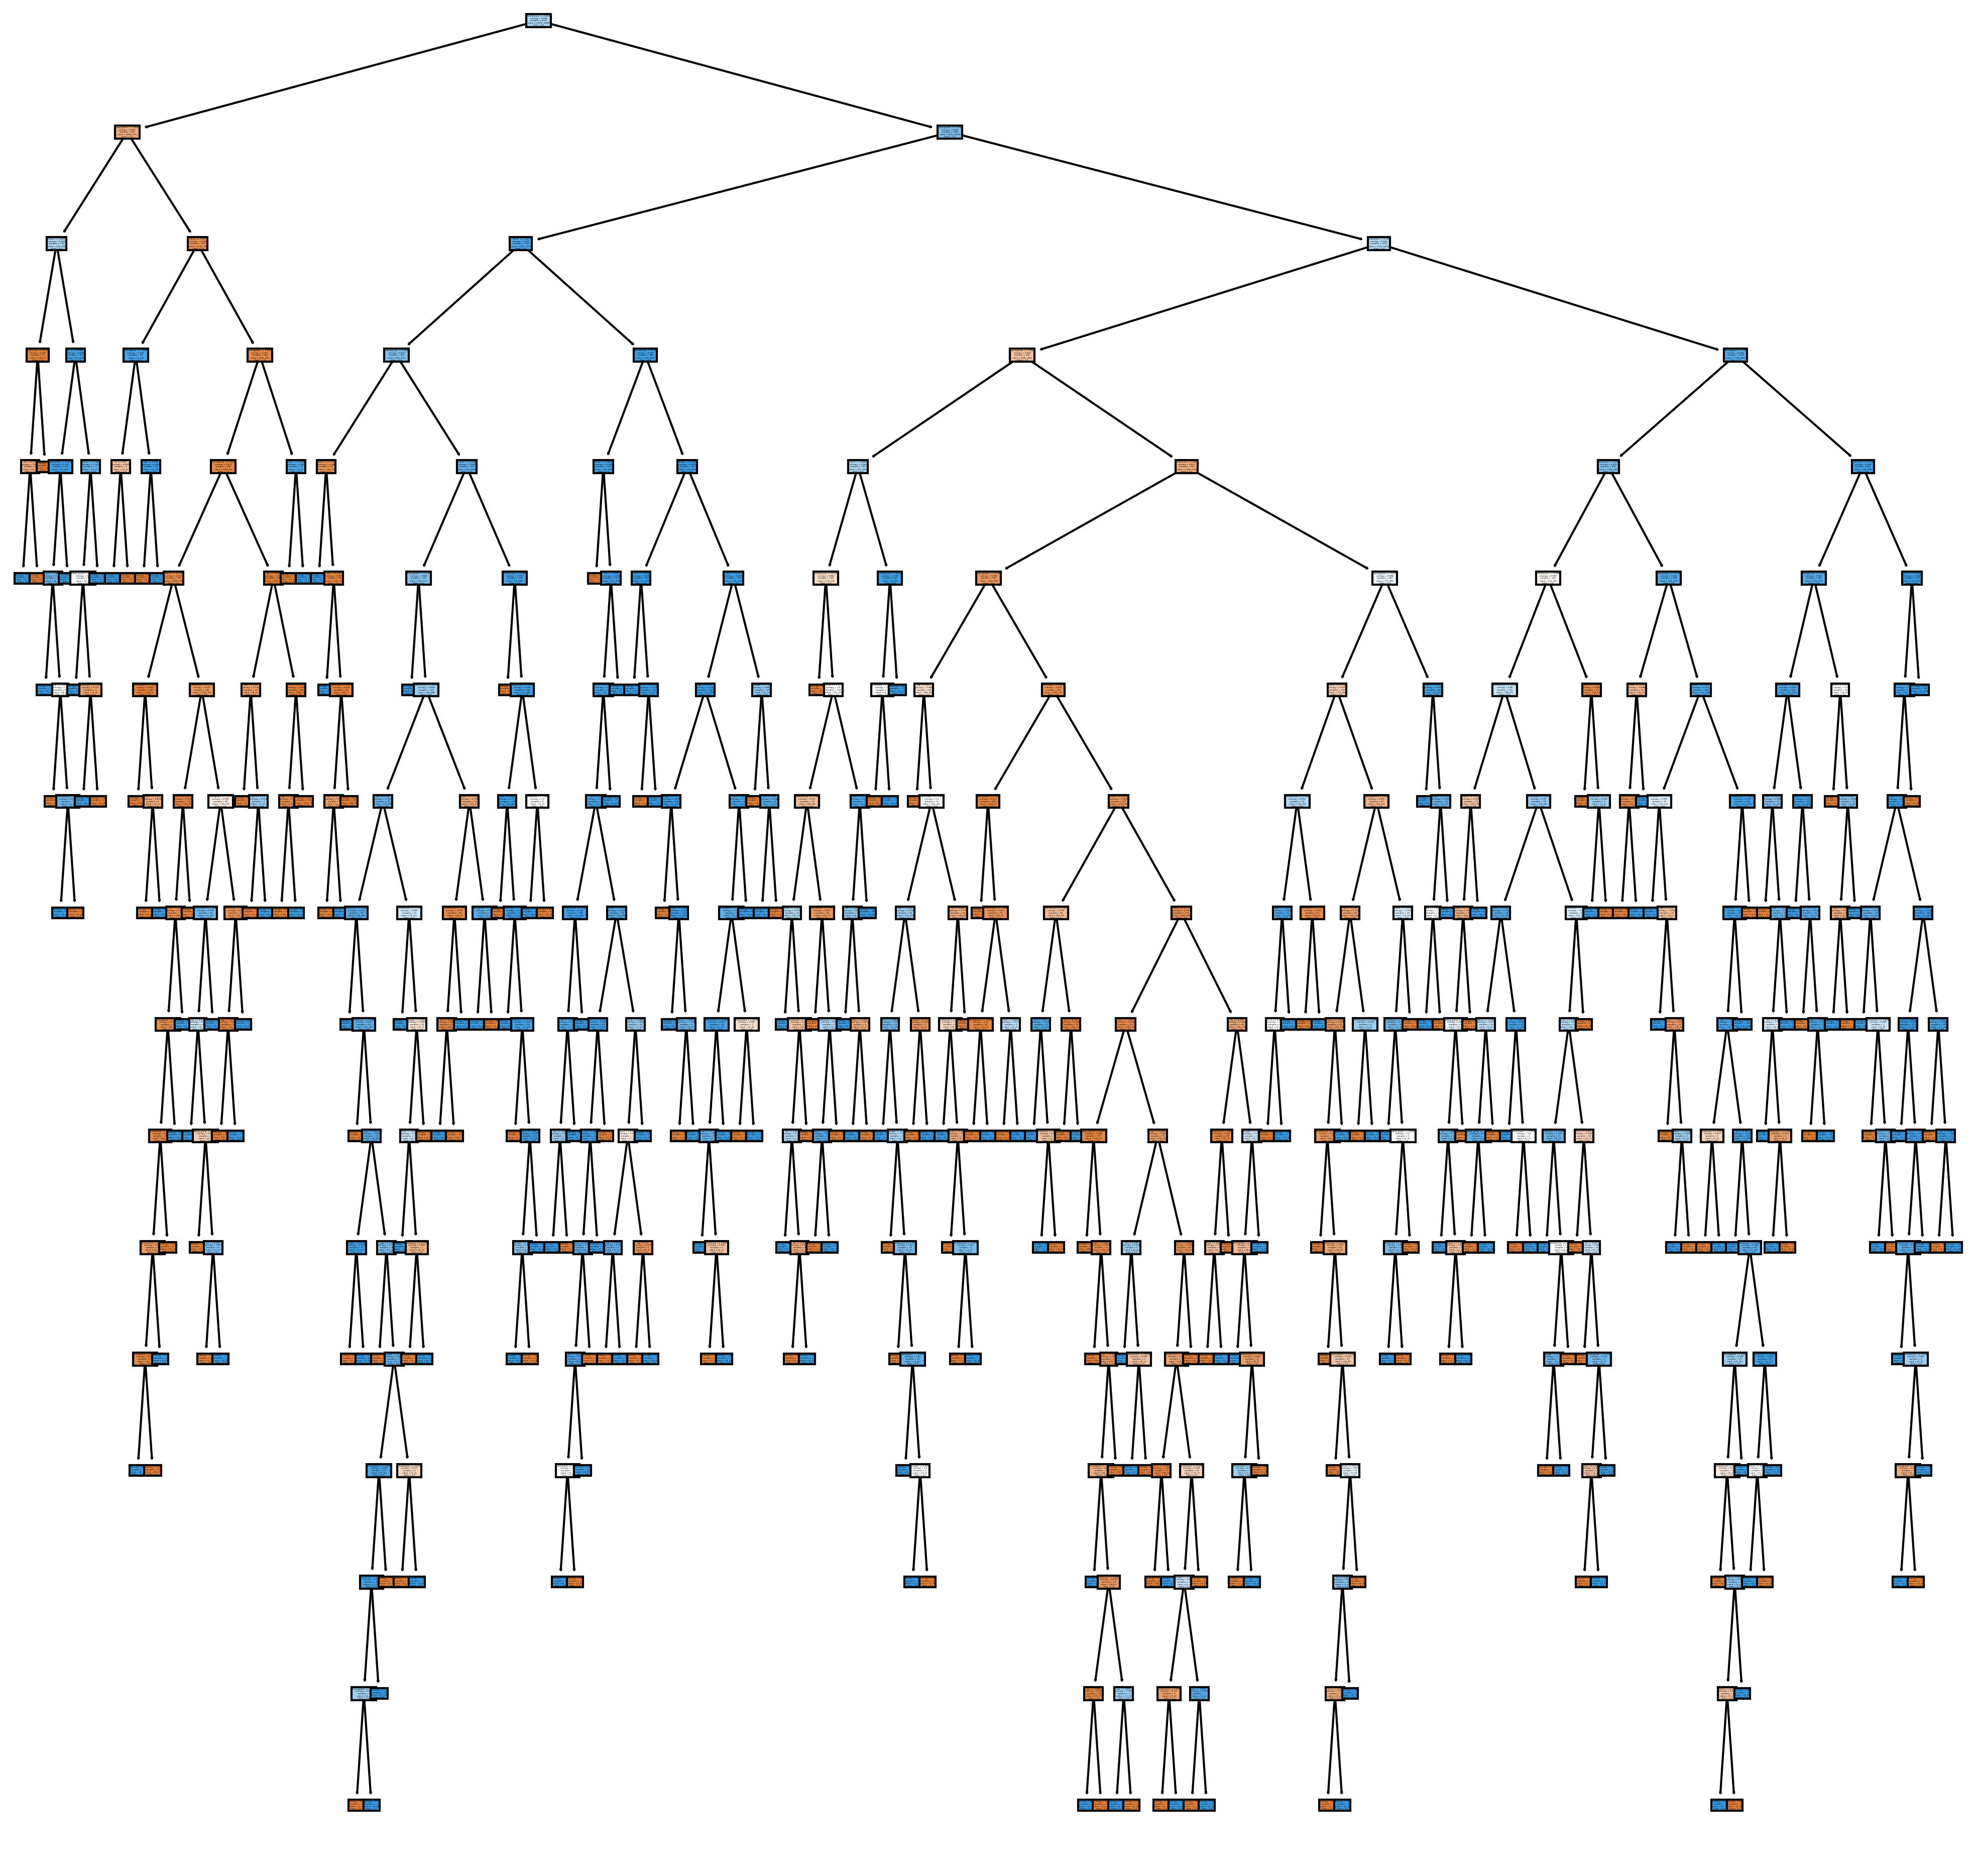

In [64]:
fig, axes = plt.subplots(figsize = (4,4), dpi=300)

plot_tree(clf,
       feature_names = X_train.columns, 
       class_names=['1.0', '0.0'],
       filled = True);

## 3. Optimalizácia - hyperparameter tuning
Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok. 
Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

### Grid search on clf

In [16]:
clf = DecisionTreeClassifier()

parameters={
    'splitter' : ['best', 'random'],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1, 3, 5, 7, 9, 11, 12],
    'min_samples_leaf' : [1, 2, 4, 6, 8, 10],
    'min_samples_split' : [2, 5, 10, 15, 20],
    'min_weight_fraction_leaf' : [0.1, 0.2, 0.3, 0.4],
    'max_features' : ['auto', 'log2', 'sqrt', None],
    'max_leaf_nodes' : [10, 20, 30, 40, 50]
}

clf_GS = GridSearchCV(clf, parameters)
clf_GS.fit(X_train, y_train)

print('Best Splitter:', clf_GS.best_estimator_.get_params()['splitter'])
print('Best Criterion:', clf_GS.best_estimator_.get_params()['criterion'])
print('Best Min_samples_leaf:', clf_GS.best_estimator_.get_params()['min_samples_leaf'])
print('Best Min_samples_split:', clf_GS.best_estimator_.get_params()['min_samples_split'])
print('Best Min_weight_fraction_leaf:', clf_GS.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best Max_features:', clf_GS.best_estimator_.get_params()['max_features'])
print('Best Max_leaf_nodes:', clf_GS.best_estimator_.get_params()['max_leaf_nodes'])
print(); print(clf_GS.best_estimator_.get_params())

Best Splitter: best
Best Criterion: gini
Best Min_samples_leaf: 8
Best Min_samples_split: 5
Best Min_weight_fraction_leaf: 0.1
Best Max_features: log2
Best Max_leaf_nodes: 20

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.1, 'random_state': None, 'splitter': 'best'}


In [204]:
clf_new = DecisionTreeClassifier(criterion='gini',
                             splitter='best',
                             max_depth=12,
                             max_features='log2',
                             max_leaf_nodes=20,
                             min_samples_leaf=8,
                             min_samples_split=5,
                             min_weight_fraction_leaf=0.1,
                             random_state=None)

decisionTree_summary_after = decisionTree(clf_new)
decisionTree_summary_after

,precision,recall,f1-score,support
0.0,0.740634,0.392966,0.513487,654.000000
1.0,0.720816,0.919283,0.808041,1115.000000
accuracy,0.724703,0.724703,0.724703,0.724703
macro avg,0.730725,0.656124,0.660764,1769.000000
weighted avg,0.728143,0.724703,0.699144,1769.000000


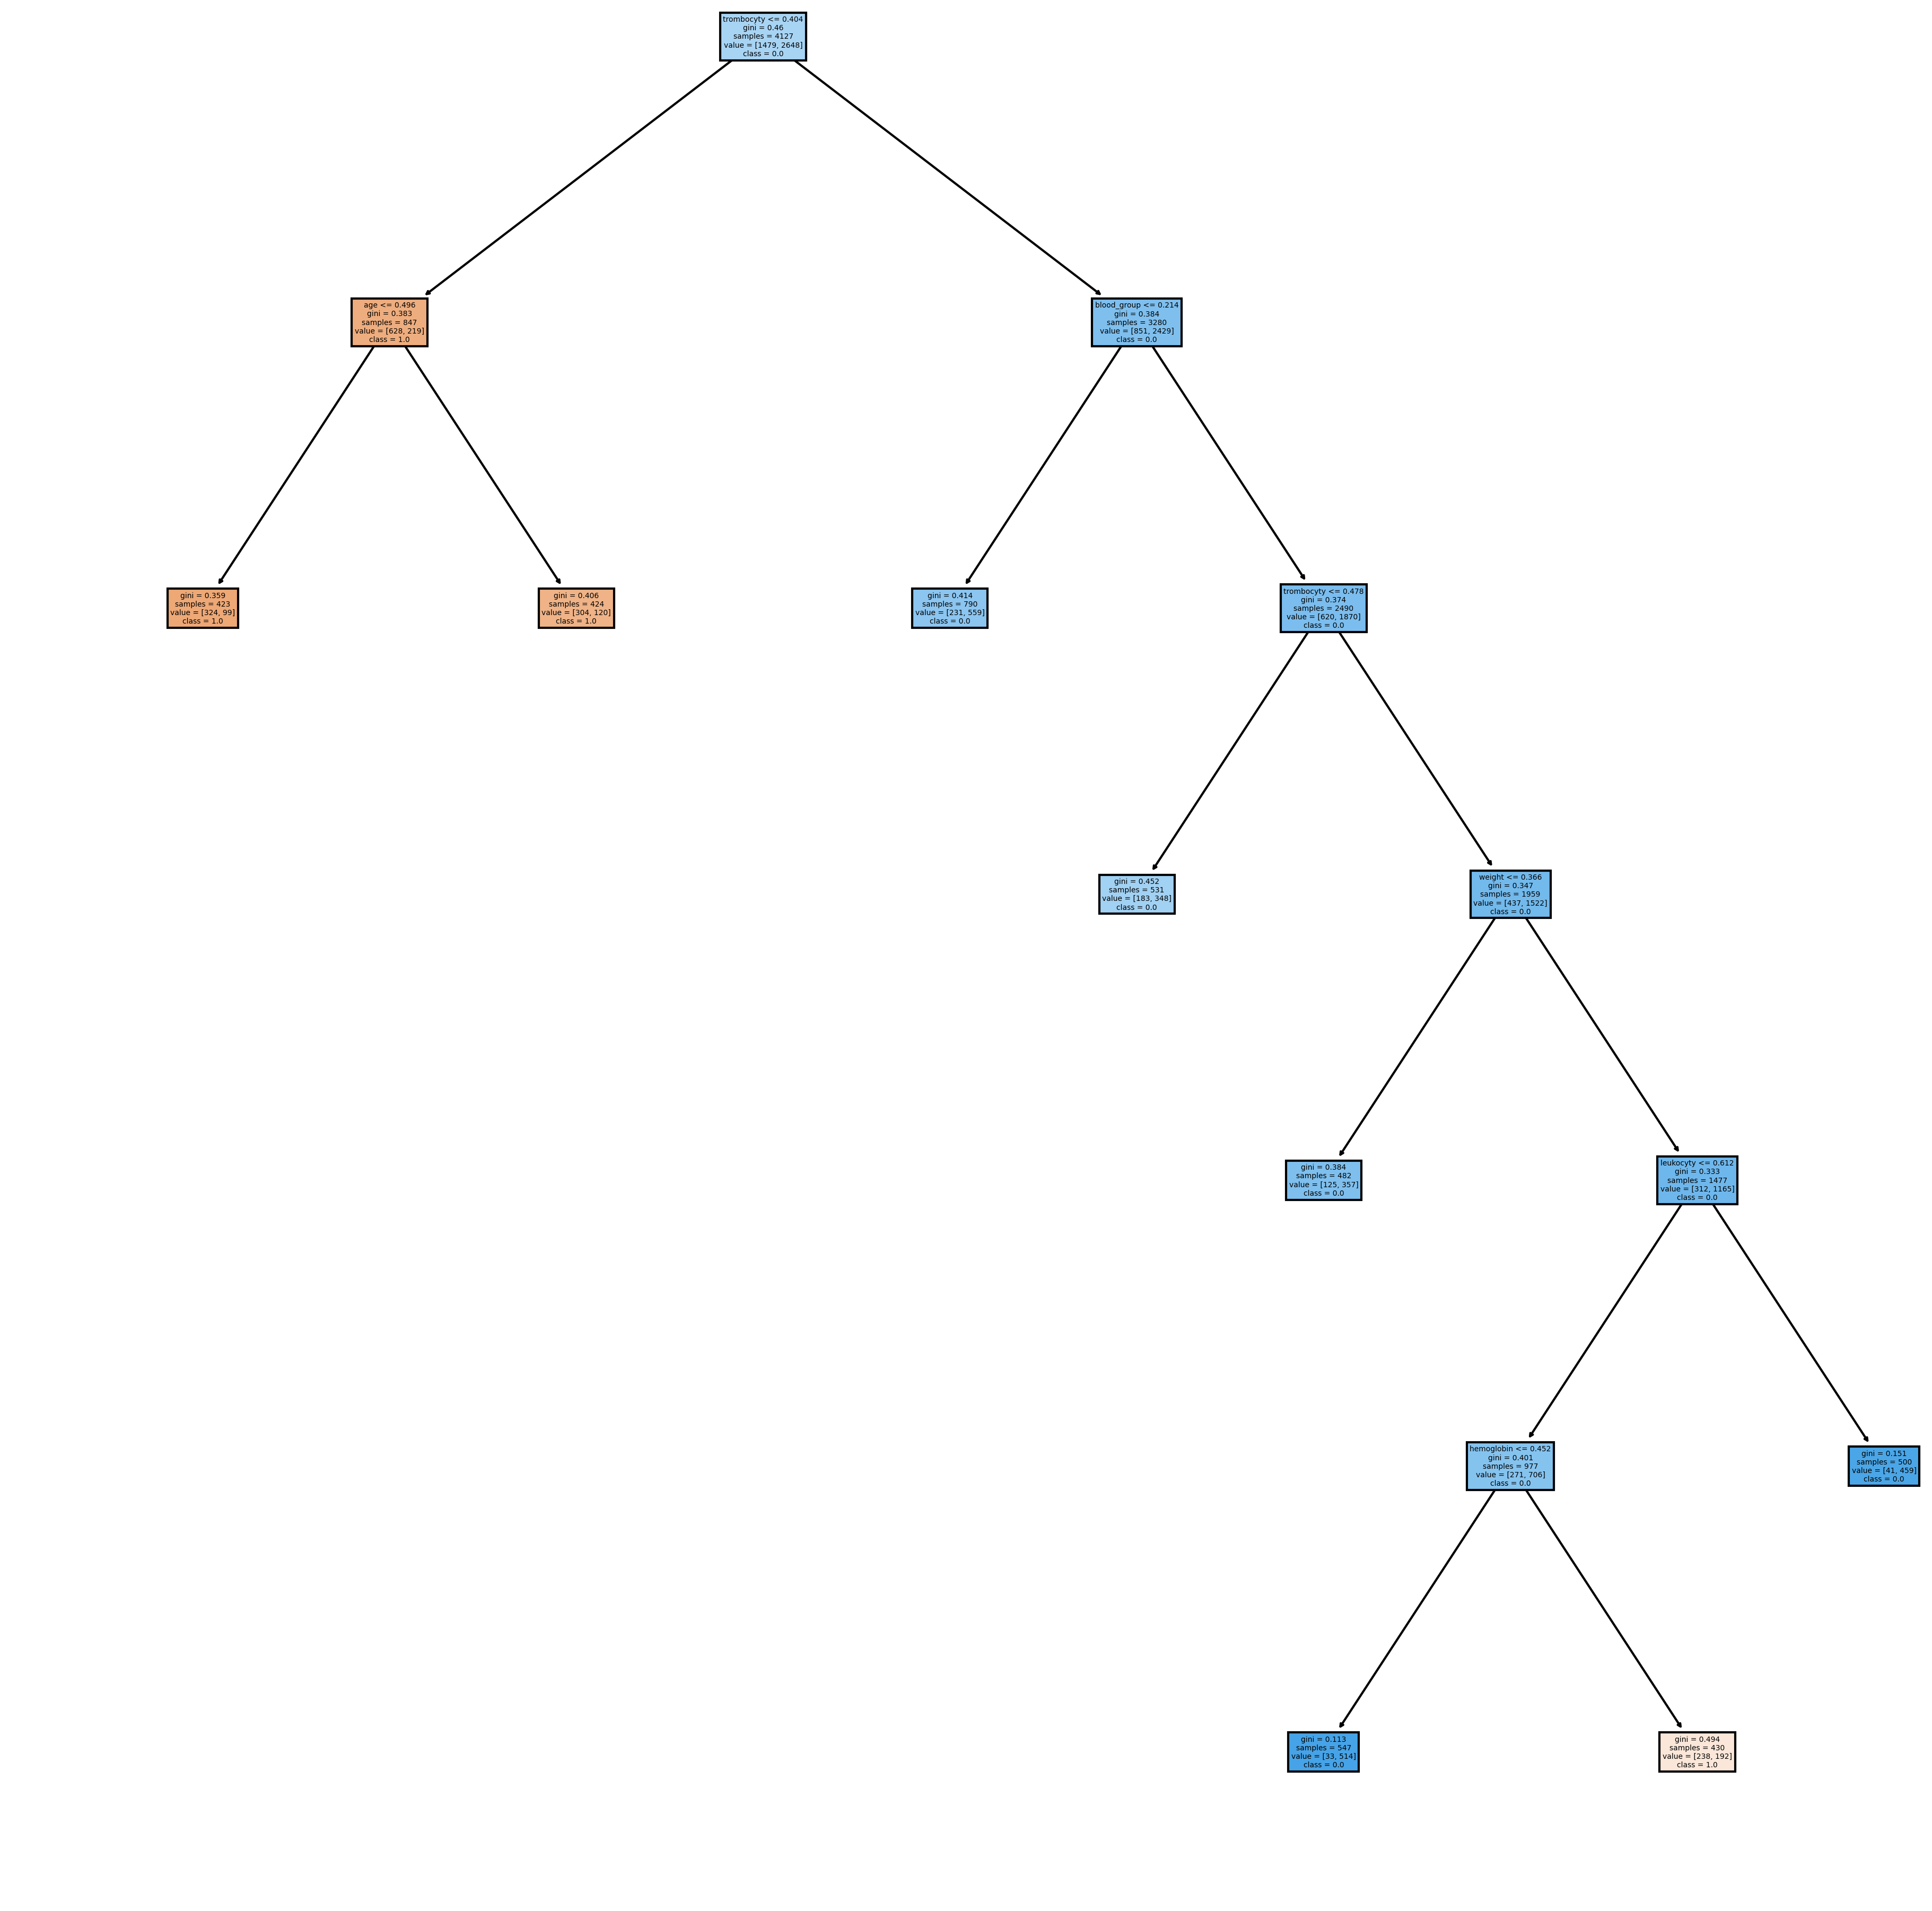

In [189]:
fig, axes = plt.subplots(figsize = (4,4), dpi=300)

plot_tree(clf_new,
       feature_names = X_train.columns, 
       class_names=['1.0', '0.0'],
       filled = True);

In [205]:
pd.concat([decisionTree_summary_after[['precision', 'recall', 'f1-score', 'support']], decisionTree_summary[['precision', 'recall', 'f1-score', 'support']]], axis=1, keys=['decisionTree_summary_after', 'decisionTree_summary_befor'])

decisionTree_summary_after                                   \
                              precision    recall  f1-score      support   
0.0                            0.740634  0.392966  0.513487   654.000000   
1.0                            0.720816  0.919283  0.808041  1115.000000   
accuracy                       0.724703  0.724703  0.724703     0.724703   
macro avg                      0.730725  0.656124  0.660764  1769.000000   
weighted avg                   0.728143  0.724703  0.699144  1769.000000   

             decisionTree_summary_befor                                   
                              precision    recall  f1-score      support  
0.0                            0.849231  0.844037  0.846626   654.000000  
1.0                            0.908847  0.912108  0.910474  1115.000000  
accuracy                       0.886942  0.886942  0.886942     0.886942  
macro avg                      0.879039  0.878072  0.878550  1769.000000  
weighted avg                   0.886807  0.886942  0.886870  1769.000000

Po nájdení optimálnych hypermarametrov vidíme, pokles pri úspešnti hodnôt Accuracy, Precision a Recall, ale nemusí to nutne znamenať, že je to zlé, pretože práve toto môže zabrániť overfitnutiu pre iné množiny nových dát. Na ktorých by sme pouźili náš model.

In [151]:
clf = DecisionTreeClassifier(max_depth=1)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.726950,0.433404,0.543046,946.000000
1.0,0.738281,0.907563,0.814216,1666.000000
accuracy,0.735835,0.735835,0.735835,0.735835
macro avg,0.732616,0.670483,0.678631,2612.000000
weighted avg,0.734177,0.735835,0.716006,2612.000000


In [152]:
clf = DecisionTreeClassifier(max_depth=2)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.855814,0.389006,0.534884,946.000000
1.0,0.735105,0.962785,0.833680,1666.000000
accuracy,0.754977,0.754977,0.754977,0.754977
macro avg,0.795460,0.675896,0.684282,2612.000000
weighted avg,0.778823,0.754977,0.725463,2612.000000


In [153]:
clf = DecisionTreeClassifier(max_depth=4)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.850340,0.792812,0.820569,946.000000
1.0,0.886705,0.920768,0.903416,1666.000000
accuracy,0.874426,0.874426,0.874426,0.874426
macro avg,0.868523,0.856790,0.861992,2612.000000
weighted avg,0.873535,0.874426,0.873411,2612.000000


In [154]:
clf = DecisionTreeClassifier(max_depth=8)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.880550,0.880550,0.880550,946.000000
1.0,0.932173,0.932173,0.932173,1666.000000
accuracy,0.913476,0.913476,0.913476,0.913476
macro avg,0.906361,0.906361,0.906361,2612.000000
weighted avg,0.913476,0.913476,0.913476,2612.000000


In [158]:
clf = DecisionTreeClassifier(max_depth=10)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.876477,0.862579,0.869473,946.000000
1.0,0.922665,0.930972,0.926800,1666.000000
accuracy,0.906202,0.906202,0.906202,0.906202
macro avg,0.899571,0.896776,0.898136,2612.000000
weighted avg,0.905937,0.906202,0.906038,2612.000000


In [159]:
clf = DecisionTreeClassifier(max_depth=9)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.885684,0.876321,0.880978,946.000000
1.0,0.930191,0.935774,0.932974,1666.000000
accuracy,0.914242,0.914242,0.914242,0.914242
macro avg,0.907937,0.906048,0.906976,2612.000000
weighted avg,0.914072,0.914242,0.914142,2612.000000


Pri testovaní zmeny Accuracy, Precision a Recall pre hyperparameter 'max_depth' som zistil, že pri jeho najlepšie hodnoty sú hodnoty 8 a 9 dovtedy sa hodnoty Accuracy, Precision a Recall zväčšujú a od 10 sa zas následne zhoršujú

In [167]:
clf = DecisionTreeClassifier(min_weight_fraction_leaf=0.1)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.699201,0.832981,0.760251,946.000000
1.0,0.893603,0.796519,0.842272,1666.000000
accuracy,0.809724,0.809724,0.809724,0.809724
macro avg,0.796402,0.814750,0.801262,2612.000000
weighted avg,0.823195,0.809724,0.812566,2612.000000


In [168]:
clf = DecisionTreeClassifier(min_weight_fraction_leaf=0.2)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.699201,0.832981,0.760251,946.000000
1.0,0.893603,0.796519,0.842272,1666.000000
accuracy,0.809724,0.809724,0.809724,0.809724
macro avg,0.796402,0.814750,0.801262,2612.000000
weighted avg,0.823195,0.809724,0.812566,2612.000000


In [169]:
clf = DecisionTreeClassifier(min_weight_fraction_leaf=0.3)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.622642,0.523256,0.568639,946.000000
1.0,0.751789,0.819928,0.784381,1666.000000
accuracy,0.712481,0.712481,0.712481,0.712481
macro avg,0.687215,0.671592,0.676510,2612.000000
weighted avg,0.705015,0.712481,0.706245,2612.000000


In [170]:
clf = DecisionTreeClassifier(min_weight_fraction_leaf=0.4)
decisionTree_summary_new = decisionTree(clf)
decisionTree_summary_new

,precision,recall,f1-score,support
0.0,0.498062,0.815011,0.618284,946.000000
1.0,0.835526,0.533613,0.651282,1666.000000
accuracy,0.635528,0.635528,0.635528,0.635528
macro avg,0.666794,0.674312,0.634783,2612.000000
weighted avg,0.713305,0.635528,0.639331,2612.000000


Pri testovaní zmeny Accuracy, Precision a Recall pre hyperparameter 'max_weight_fraction_leaf' som zistil, že jeho najlepšie hodnoty sú hodnoty 0.1 vtedy sú hodnoty ešte značne dobré, ale jeho postupným zväčšovaním vidíme rapídny pokles úspešnosti.

## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy: 

Stratégie riešenia chýbajúcich hodnôt a outlierov;
Scaling resp. transformer či zlepší accuracy klasifikácie;
Výber atribútov a výber algoritmov;
Hyperparameter tuning resp. ensemble learning.
Ktorý spôsob z každého hore-uvedených bodov sa ukázal ako vhodnejší pre daný problém? Vyhodnotenie podložíte dôkazmi.

In [140]:
df = pd.read_csv('dataset/raw_unscaled_nan.csv')
df.drop(columns=['ssn'], inplace=True)

Missing data inputation methods:

In [141]:
def drop_missing(df):
    df.dropna(inplace=True)
    return df

# Fill missing values 
# Input by median all columns
def fill_median(df):
    cols = df.columns[df.isnull().any()]
    for col in cols:
        df[col].fillna(df[col].median(), inplace=True)
    return df

# Fill missing values 
from sklearn.impute import SimpleImputer
# Input be mean 
def fill_mean(df):
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
    return df

# Inputation by KNN
from sklearn.impute import KNNImputer
def fill_k(df):
    imputer = KNNImputer(n_neighbors=5)
    df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
    return df

Scaling methods:

In [145]:
# define min max scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def min_max_scaler(x):
    X = x.loc[:, x.columns != 'indicator']
    scaler = MinMaxScaler()# transform data
    X = scaler.fit_transform(X)
    y = x['indicator']
    return X, y

# define standard scaler
def standard_scaler(x):
    X = x.loc[:, x.columns != 'indicator']
    scaler = StandardScaler()# transform data
    X = scaler.fit_transform(X)
    y = x['indicator']
    return X, y


In [149]:
inputers = [drop_missing, fill_median, fill_mean, fill_k]
scalers = [min_max_scaler, standard_scaler]
results = []
for inputer in inputers:
    df = pd.read_csv('dataset/raw_unscaled_nan.csv')
    df.drop(columns=['ssn'], inplace=True)
    df = inputer(df)
    for scaler in scalers: 
        X, y = scaler(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        results.append({
            'name' : 'DecisionTree',
            'method' : str(inputer).split(' ')[1] + ' + '  +  str(scaler).split(' ')[1],
            'results': decisionTree(clf_new)
        })

In [150]:
for result in results:
    print(result['name'])
    print(result['method'])
    print(result['results'])
    print('\n')

DecisionTree
drop_missing + min_max_scaler
              precision    recall  f1-score     support
0.0            0.918429  0.336283  0.492308   904.00000
1.0            0.726776  0.983364  0.835821  1623.00000
accuracy       0.751880  0.751880  0.751880     0.75188
macro avg      0.822602  0.659824  0.664064  2527.00000
weighted avg   0.795337  0.751880  0.712934  2527.00000


DecisionTree
drop_missing + standard_scaler
              precision    recall  f1-score      support
0.0            0.717742  0.787611  0.751055   904.000000
1.0            0.874919  0.827480  0.850538  1623.000000
accuracy       0.813217  0.813217  0.813217     0.813217
macro avg      0.796330  0.807545  0.800797  2527.000000
weighted avg   0.818691  0.813217  0.814949  2527.000000


DecisionTree
fill_median + min_max_scaler
              precision    recall  f1-score      support
0.0            0.754696  0.721987  0.737979   946.000000
1.0            0.845929  0.866747  0.856211  1666.000000
accuracy       0.8

Pri testovaní rôznych dvojíc stratégii pre náš DecisionTree sme dospeli k záveru, že najlepšia dvojica bola "fill_median + min_max_scaler" a tesne zaňou "drop_missing + standard_scaler".
Najhoršie z tohto testu vyšlia dvojica fill_mean + min_max_scaler.
Ostatné dvojice sa pohybovali na docela dobrej úspešnosti.

In [206]:
pd.concat([decisionTree_summary_after[['precision', 'recall', 'f1-score', 'support']], oneR_summary[['precision', 'recall', 'f1-score', 'support']]], axis=1, keys=['decisionTree_summary_after', 'oneR_summary'])

decisionTree_summary_after                                   \
                              precision    recall  f1-score      support   
0.0                            0.740634  0.392966  0.513487   654.000000   
1.0                            0.720816  0.919283  0.808041  1115.000000   
accuracy                       0.724703  0.724703  0.724703     0.724703   
macro avg                      0.730725  0.656124  0.660764  1769.000000   
weighted avg                   0.728143  0.724703  0.699144  1769.000000   

             oneR_summary                                   
                precision    recall  f1-score      support  
0.0              0.683955  0.460699  0.550554   916.000000  
1.0              0.741361  0.878957  0.804317  1611.000000  
accuracy         0.727345  0.727345  0.727345     0.727345  
macro avg        0.712658  0.669828  0.677436  2527.000000  
weighted avg     0.720552  0.727345  0.712332  2527.000000

Podľa tejto tabuľky by sme mohli povedať, že DecisionTree po vybratí optimálnych parametrov pomocou gridSearch vyhodilo veľmi podobné hodnoty nášmu vlastne naimplementovanému oneR. Mohli by sme teda povedať, že pri oneR vyśli docela pekné výsledky, pretože po tuningu DecisionTree s hepyrparametrami máme takmer rovnaké výsledky.

Nakoniec by sme chceli dodať, že nás táto fáza začala veľmi baviť a bolo skvelé pozerať ako rôzne stratégie dokážu dané riešenie zlepšiť či zhoršiť.